## 0) 데이터 전처리
* Baseline코드에서 사용했던 전처리 방식을 그대로 사용
* index column은 학습에 관련이 없으니 제거

In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

train = pd.read_csv("../data/train.csv")                            #r*c = 20000*20, test와 달리 credit이라는 column을 갖고 있고, 이 값을 예측
test = pd.read_csv("../data/test.csv")                              #10000*19. train으로 학습시키고 test데이터를 입력으로 넣어서 credit을 예측
sample_submission = pd.read_csv("../data/sample_submission.csv")    #예측값은 sample_submission과 형태가 같아야 함.

In [2]:
data = pd.concat([train, test], axis=0)    # train데이터 밑에 test데이터가 붙음. test에는 credit이 없으므로, 결측치(NaN)형태로 저장됨
# 실제로는 결측치를 완전히 날리는건 좋지 않지만, 1회 출제용으로 사용하기때문에 완전히 날림
data = data.drop("occyp_type", axis=1) # occyp_type column을 지움. axis : occyp_type이 row에 있는지 column에 있는지 알려줌. 1이면 column

In [3]:
unique_len = data.apply(lambda x : len(x.unique()))  # 각 column별로 unique()를 수행하여, 그 길이를 반환. 즉, 모든 column의 요소의 개수를 출력
group_1 = unique_len[unique_len <= 2].index   # 요소의 값이 2개 이하인 column들의 이름을 추출
group_2 = unique_len[(unique_len > 2) & (unique_len <= 10)].index
group_3 = unique_len[(unique_len > 10)].index

In [4]:
data['gender'] = data['gender'].replace(['F','M'], [0, 1])   # F를 0으로, M을 1로 교체
data['car'] = data['car'].replace(['N', 'Y'], [0, 1])
data['reality'] = data['reality'].replace(['N', 'Y'], [0,1])

In [5]:
data.loc[data['child_num']>2, 'child_num'] = 2  # child_num>2인 child_num column을 가져와서 2로 바꿈
data[group_2].apply(lambda x : len(x.unique()))
label_encoder = preprocessing.LabelEncoder() # categorical 변수(문자로 되어있는 변수)들을 숫자로 인코딩해주는 함수
set(label_encoder.fit_transform(data['income_type'])) # income_type column에서 각 요소들을 숫자로 바꿔줌. fit_transform이 배열을 반환해서 unique()대신 set을 사용
data['income_type'] = label_encoder.fit_transform(data['income_type'])
data['edu_type'] = label_encoder.fit_transform(data['edu_type'])
data['family_type'] = label_encoder.fit_transform(data['family_type'])
data['house_type'] = label_encoder.fit_transform(data['house_type'])

In [6]:
counts, bin_dividers = np.histogram(data['income_total'], bins=7) # 연속형 변수를 입력으로 받아 몇 개의 구간으로 나눌지 설정해줌. 각 구간들의 분절점(나누는 기준) 및 구간별 요소의 개수를 출력해줌
data['income_total'] = pd.factorize(pd.cut(data['income_total'], bins = bin_dividers, include_lowest=True, labels=[0,1,2,3,4,5,6]))[0] # pd.cut의 반환 데이터 타입은 category이기 때문에, series타입(int형 배열)으로 바꿔주는 작업을 거쳐야 함
#위의 과정을 함수로 만듬
def make_bin(array, N):
    array = -array      #DAYS_BIRTH등의 column은 음수이기 때문에 양수로 바꿔줌
    _, bin_dividers = np.histogram(array, bins = N)       # 여기선 counts 변수를 사용하지 않을 것이기 때문에 사용하지 않는다는 의미로 _로 설정.
    cut_categories = pd.cut(array, bin_dividers, labels = [i for i in range(N)], include_lowest=True)
    bined_array = pd.factorize(cut_categories)[0]
    return bined_array
data['DAYS_BIRTH'] = make_bin(data['DAYS_BIRTH'], 10)
data['DAYS_EMPLOYED'] = make_bin(data['DAYS_EMPLOYED'], 10)
data['begin_month'] = make_bin(data['begin_month'], 10)

In [7]:
data=data.drop('index', axis=1)
train = data[:-10000]   # train에 해당하는 값
test = data[-10000:]   #test에 해당하는 값
train_x = train.drop("credit", axis = 1) # credit은 출력값이고, credit을 제외한 값들이 모델의 입력값이므로 column들 중(axis =1) credit을 찾아 없앰.
train_y = train['credit']               # 모델의 출력이 credit
test_x = test.drop("credit", axis=1)        # data라는 dataframe을 만들면서 test set에 없던 credit이라는 column이 생겼으므로, 이를 다시 제거

## 1) RandomForestClassifier

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.2, random_state=10086)

In [11]:
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)
predict = clf.predict_proba(X_val)
y_val_onehot = pd.get_dummies(Y_val)
logloss = log_loss(y_val_onehot, predict)
print(logloss)

1.466047343279552


### 1_1) 하이퍼파라미터 조정

In [26]:
rf_param_grid = {
    'n_estimators' : [100, 200],
    'max_depth' : [8, 10, 12],
    'min_samples_leaf' : [3, 5, 7],
    'min_samples_split' : [3, 4, 5]
}

In [27]:
from sklearn.model_selection import GridSearchCV

X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.25, random_state=10086)

clf = RandomForestClassifier()
clf_grid = GridSearchCV(clf, param_grid=rf_param_grid, scoring="accuracy", n_jobs=-1, verbose=2)
clf_grid.fit(X_train, Y_train)

predict = clf_grid.predict_proba(X_val)
y_val_onehot = pd.get_dummies(Y_val)
logloss=log_loss(y_val_onehot, predict)
print(logloss)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.8262986236456679


In [28]:
folds = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 55)  # 5개의 fold로 나눔

outcomes = []
for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    Y_train, Y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    clf = RandomForestClassifier()
    clf_grid = GridSearchCV(clf, param_grid=rf_param_grid, scoring="accuracy", n_jobs=-1, verbose=2)
    clf_grid.fit(X_train, Y_train)
    predictions = clf_grid.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(Y_val)

    logloss = log_loss(y_val_onehot, predictions)
    outcomes.append(logloss)

print(outcomes)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[0.8282641291283019, 0.8225467954824329, 0.8253606275571261, 0.8224319510375313, 0.8201274143462735]


## 2) Gradient Boosting

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.25, random_state=10086)

gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)
predict = gb.predict_proba(X_val)
y_val_onehot = pd.get_dummies(Y_val)
logloss = log_loss(y_val_onehot, predict)
print(logloss)

0.8335746908166416


In [31]:
folds = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 55)  # 5개의 fold로 나눔

outcomes = []
for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    Y_train, Y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    gb = GradientBoostingClassifier()
    gb.fit(X_train, Y_train)
    predictions = gb.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(Y_val)

    logloss = log_loss(y_val_onehot, predictions)
    outcomes.append(logloss)
print(outcomes)

[0.8417415560977669, 0.8341085098795408, 0.8386208102239824, 0.8392900501671904, 0.8335760935299279]


### 2_1) Gradient Boosting parameter 조정
* **주의. 한번 실행에 시간 소요가 너무 김**

In [43]:
gb_param_grid = {
    'n_estimators' : [100, 200],
    'max_depth' : [8, 10, 12],
    'min_samples_leaf' : [5, 7, 10],
    'min_samples_split' : [2, 3, 5],
    'learning_rate' : [0.05, 0.1, 0.2]
}

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

gb = GradientBoostingClassifier()
gb_grid = GridSearchCV(gb, param_grid = gb_param_grid, scoring="accuracy", n_jobs=-1, verbose=3)
gb_grid.fit(X_train, Y_train)
predict = gb_grid.predict_proba(X_val)
y_val_onehot = pd.get_dummies(Y_val)
logloss = log_loss(y_val_onehot, predict)
print(logloss)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


KeyboardInterrupt: 

In [34]:
gb_grid.best_params_

{'learning_rate': 0.05,
 'max_depth': 8,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_estimators': 100}

In [48]:
folds = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 55)  # 5개의 fold로 나눔

outcomes = []
for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    Y_train, Y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=8, min_samples_leaf=7, min_samples_split=2)
    gb.fit(X_train, Y_train)
    predict = gb.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(Y_val)
    logloss = log_loss(y_val_onehot, predict)
    outcomes.append(logloss)
print(outcomes)

[0.8299092537458699, 0.8195784379737493, 0.822702511343288, 0.8219319425895892, 0.8183218626777928]


## 3) AdaBoost

In [51]:
from sklearn.ensemble import AdaBoostClassifier

X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.25, random_state=10086)

ag = AdaBoostClassifier()
ag.fit(X_train, Y_train)

predict = ag.predict_proba(X_val)
y_val_onehot = pd.get_dummies(Y_val)
log_loss(y_val_onehot, predict)

1.0877788002340585

## 4) XgBoost

In [52]:
from xgboost import XGBClassifier

outcomes = []
for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    Y_train, Y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    xgb = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth = 4, use_label_encoder=False)
    xgb.fit(X_train, Y_train)
    predictions = xgb.predict_proba(X_val)
    y_val_onehot = pd.get_dummies(Y_val)

    logloss = log_loss(y_val_onehot, predictions)
    outcomes.append(logloss)
print(outcomes)

[20:56:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
d:\pythonenv\mlenv\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
[20:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
d:\pythonenv\mlenv\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra co

### 4_1) XgBoost hyperparameter tuning
* **주의. 한번 실행에 시간 소요가 너무 김**

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb_param_grid = {
    'n_estimators' : [300, 500, 600],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15],
    'max_depth' : [3, 4, 6, 8]
}

xgb_grid = GridSearchCV(xgb, param_grid = xgb_param_grid, scoring="accuracy", n_jobs= -1, verbose = 3)
xgb_grid.fit(X_train, Y_train)

In [ ]:
'''
실행 시간이 너무 오래 걸려 전에 돌려놨던 결과로 대체함
Fitting 5 folds for each of 1 candidates, totalling 5 fits
c:\Users\lijm1\Desktop\pythonenv\mlenv\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[01:20:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [4],
                         'n_estimators': [500]},
             scoring='accuracy', verbose=3)
'''

In [53]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.25, random_state=10086)

xgb = XGBClassifier(n_estimators=500, learning_rate=0.01, max_depth = 4, use_label_encoder=False)
xgb.fit(X_train, Y_train)
predictions = xgb.predict_proba(X_val)
y_val_onehot = pd.get_dummies(Y_val)

log_loss(y_val_onehot, predictions)

[20:57:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
d:\pythonenv\mlenv\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.8359875737021389

## 5) LightGBM

In [26]:
from lightgbm import LGBMClassifier, plot_importance

X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.25, random_state=10086)

lgb = LGBMClassifier(n_estimators=400)
lgb.fit(X_train, Y_train)
predict = lgb.predict_proba(X_val)
y_val_onehot = pd.get_dummies(Y_val)
log_loss(y_val_onehot, predict)

0.8248750259707588

### 5_1) LGBM Early stopping 적용

In [55]:
lgb = LGBMClassifier(n_estimators=1000)
evals = [(X_val, Y_val)]
lgb.fit(X_train, Y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
predict = lgb.predict_proba(X_val)
y_val_onehot = pd.get_dummies(Y_val)
logloss = log_loss(y_val_onehot, predict)

[1]	valid_0's multi_logloss: 0.871384
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.863215
[3]	valid_0's multi_logloss: 0.857059
[4]	valid_0's multi_logloss: 0.852325
[5]	valid_0's multi_logloss: 0.848258
[6]	valid_0's multi_logloss: 0.84532
[7]	valid_0's multi_logloss: 0.842952
[8]	valid_0's multi_logloss: 0.840694
[9]	valid_0's multi_logloss: 0.83901
[10]	valid_0's multi_logloss: 0.837603
[11]	valid_0's multi_logloss: 0.836505
[12]	valid_0's multi_logloss: 0.835527
[13]	valid_0's multi_logloss: 0.834671
[14]	valid_0's multi_logloss: 0.833793
[15]	valid_0's multi_logloss: 0.833183
[16]	valid_0's multi_logloss: 0.83234
[17]	valid_0's multi_logloss: 0.831761
[18]	valid_0's multi_logloss: 0.831425
[19]	valid_0's multi_logloss: 0.830885
[20]	valid_0's multi_logloss: 0.830542
[21]	valid_0's multi_logloss: 0.830351
[22]	valid_0's multi_logloss: 0.830166
[23]	valid_0's multi_logloss: 0.830036
[24]	valid_0's multi_logloss: 0.829671
[25]	valid_0's

In [56]:
logloss

0.8156847808255132

## 6) TabNet

In [46]:
import torch
import matplotlib.pyplot as plt

In [47]:
torch.cuda.is_available()

True

In [48]:
X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.18, random_state=10086)

In [12]:
'''
from tqdm.notebook import tqdm

features = [col for col in train_x.columns]

categorical_columns = []
categorical_dims = {}

for col in tqdm(train_x.columns):
    l_enc = preprocessing.LabelEncoder()
    l_enc.fit_transform(train_x[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
'''

  0%|          | 0/17 [00:00<?, ?it/s]

### Hyperparameter 정리
#### * https://github.com/dreamquark-ai/tabnet 및 https://arxiv.org/pdf/1908.07442.pdf 를 참고함. 더 자세한 내용이나 추가 Hyperparameter는 여기로
- 모델 파라미터
* <code>n_d</code> = decision prediction layer의 층. 값이 클수록 featrue특징을 더 잘 잡아내지만, 오버피팅될 확률이 높음. 8~64값
* <code>n_a</code> = Width of the attention embedding for each mask. 논문에서는 n_d == n_a가 되도록 추천함.
* <code>n_steps</code> = decision step. 정보를 담은 feature들이 많다면 높은 값을 주는 것이 좋지만, 너무 높으면 성능을 떨어뜨리고 오버피팅될 확률이 높음. 3~10
* <code>gamma</code> = This is the coefficient for feature reusage in the masks(?). 한번 선택된 feature가 다시 사용될지를 결정하는 hyperparameter. 논문에서는 성능에 큰 역할을 하고, n_steps가 높을수록 gamma값도 높이는 것을 추천. 1.0~2.0
* <code>momentum</code> = 배치 정규화 모멘텀 값. 0.01~0.4
* <code>lambda_sparse</code> = sparsity loss coefficient. 이것도 잘... 적당히 높이면 학습에 도움을 준다고 나와있음
* <code>optimizer_fn</code> = 신경망 최적화 함수. Adam을 주로 사용
* <code>optimizer_params</code> = optimizer_fn에 넣어줄 parameter. optimizer_fn이 Adam이라면 초기 학습률을 parameter로 받음. 기본값이 dict(lr=2e-2)
* <code>scheduler_fn</code> = 학습률 scheduler. 여기서는 단계별로 학습률을 감쇠시키는 StepLR사용
* <code>scheduler_params</code> = scheduler_fn에 넣어줄 parameter. 여기서는 감쇠율 gamma와 몇 단계 후 감쇠시킬지 정하는 step_size를 설정
* <code>device_name</code> = 'cpu'로 설정하면 cpu, 'cuda'로 설정하면 nvidia gpu사용. gpu 사용하려면 cuda 11.1버전 필요(그 이상 버전은 아직 지원 안하는듯)
* <code>mask_type</code> = featrue선택에 사용하는 masking function(?). sparsemax 또는 entmax 둘 중 하나 사용.
- Fit 파라미터
* <code>max_epochs</code> = 최대 epoch
* <code>patience</code> = 지정해준 patience만큼의 epoch동안, 학습의 향상이 이루어지지 않으면, 학습을 중단하고 제일 결과가 잘 나온 것의 가중치로 설정. 0으로 하면 조기 종료 없이 계속 진행
* <code>loss_fn</code> = loss function 지정
* <code>batch_size</code> = 메모리 크기가 되는 한 크게 잡아주는게 좋다고 하는데 batch 크기도 logloss에 영향을 주니 잘 조절하는것이 좋을듯
* <code>virtual_batch_size</code> = ghost batch normalization(?)에 사용된다고 함. 작은 값이 좋고, batch_size값을 나눌 수 있어야 함.
* <code>num_workers</code> = GPU연산 시 사용할 cpu코어 개수를 설정한다는데... 오히려 설정하니까 더 느림. CPU보다 GPU가 훨씬 좋으면 어느정도 설정해주는 게 좋아보임
* <code>drop_last</code> = 맨 마지막, 남는 배치를 쓸지 안쓸지 결정

* **주의. 한번 실행에 시간 소요가 너무 김(약 1시간)**


In [50]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier

clf = TabNetMultiTaskClassifier(
    n_d=16, n_a=16, n_steps=5,
    lambda_sparse=1e-2,
    gamma = 1.3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95, "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',
    device_name='cuda'
)
clf.fit(
    X_train = X_train.values, y_train = np.array(Y_train).reshape(Y_train.shape[0],1),
    eval_set = [(X_val.values, np.array(Y_val).reshape(Y_val.shape[0],1))],
    max_epochs=300,
    patience=60,
    batch_size=8192,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

Device used : cuda
epoch 0  | loss: 3.81459 | val_0_logloss: 5.64735 |  0:00:01s
epoch 1  | loss: 1.28557 | val_0_logloss: 2.12134 |  0:00:03s
epoch 2  | loss: 1.03773 | val_0_logloss: 1.38402 |  0:00:05s
epoch 3  | loss: 0.98534 | val_0_logloss: 1.11979 |  0:00:07s
epoch 4  | loss: 0.93837 | val_0_logloss: 1.02961 |  0:00:09s
epoch 5  | loss: 0.9175  | val_0_logloss: 0.98219 |  0:00:11s
epoch 6  | loss: 0.90652 | val_0_logloss: 0.99071 |  0:00:13s
epoch 7  | loss: 0.89724 | val_0_logloss: 0.99378 |  0:00:15s
epoch 8  | loss: 0.89369 | val_0_logloss: 0.98137 |  0:00:17s
epoch 9  | loss: 0.89046 | val_0_logloss: 0.96116 |  0:00:19s
epoch 10 | loss: 0.88661 | val_0_logloss: 0.94896 |  0:00:21s
epoch 11 | loss: 0.8849  | val_0_logloss: 0.93632 |  0:00:23s
epoch 12 | loss: 0.88414 | val_0_logloss: 0.92281 |  0:00:25s
epoch 13 | loss: 0.8811  | val_0_logloss: 0.91622 |  0:00:27s
epoch 14 | loss: 0.87958 | val_0_logloss: 0.91203 |  0:00:29s
epoch 15 | loss: 0.88089 | val_0_logloss: 0.9036  |

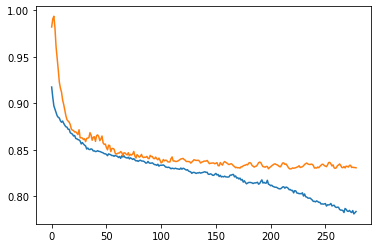

In [51]:
#clf.history['loss']
plt.plot(clf.history['loss'][5:])
plt.plot(clf.history['val_0_logloss'][5:])

In [52]:
predict = clf.predict_proba(X_val.values)
predict = np.array(predict)
predict = pd.DataFrame(predict.reshape(predict.shape[1],3), columns=[0.0, 1.0, 2.0])

In [53]:
y_val_onehot = pd.get_dummies(Y_val)
log_loss(y_val_onehot, predict)

0.8292999066046411

* n_d=8, n_a=8, n_steps=5, lambda_sparse=1e-1, gamma = 1.3, scheduler_params = {"gamma": 0.95, "step_size": 20} = **0.8380463815163395**
* n_d=8, n_a=8, n_steps=5, lambda_sparse=1e-2, gamma = 1.3, scheduler_params = {"gamma": 0.95, "step_size": 20} = **0.8327229226728547**
* n_d=8, n_a=8, n_steps=5, lambda_sparse=1e-3, gamma = 1.3, scheduler_params = {"gamma": 0.95, "step_size": 20} = **0.8373788992342593**
* n_d=16, n_a=16, n_steps=5, lambda_sparse=1e-2, gamma = 1.3, scheduler_params = {"gamma": 0.95, "step_size": 20} = **0.8265579702642575**
* 나머지 hyperparameter에 대해서는 logloss가 잘 나오지 않았음. 추후 이것저것 더 해볼 예정

In [54]:
clf.feature_importances_

array([0.00882648, 0.03877237, 0.04557721, 0.11152691, 0.01798807,
       0.0165193 , 0.03604957, 0.07089741, 0.02188411, 0.04779797,
       0.08276292, 0.02145794, 0.07950223, 0.05027626, 0.03550007,
       0.07715966, 0.23750152])

### 6_1) unsupervised pretraining test
* 논문에서 unsupervised training시 효과가 더 좋다고 나와있고, TabNet을 구현한 github repo에서도 해당 기능을 만들어놨는데, 아직까지는 별로 효과가 없어보임.

In [58]:
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier

unsupervised_model = TabNetPretrainer(
    optimizer_fn = torch.optim.Adam,
    optimizer_params = dict(lr=2e-2),
    mask_type='entmax'
)

unsupervised_model.fit(
    X_train = X_train.values,
    eval_set = [X_val.values],
    pretraining_ratio=0.8
)

clf = TabNetMultiTaskClassifier(
    n_d=16, n_a=16, n_steps=5,
    lambda_sparse=1e-2,
    gamma = 1.3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),
    scheduler_params = {"gamma": 0.9, "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',
    device_name='cuda'
)

clf.fit(
    X_train = X_train.values, y_train = np.array(Y_train).reshape(Y_train.shape[0],1),
    eval_set = [(X_val.values, np.array(Y_val).reshape(Y_val.shape[0],1))],
    max_epochs=300,
    patience=50,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

Device used : cuda
epoch 0  | loss: 14736106.94823| val_0_unsup_loss: 2141943.5|  0:00:01s
epoch 1  | loss: 451335.21824| val_0_unsup_loss: 765179.4375|  0:00:03s
epoch 2  | loss: 126466.2554| val_0_unsup_loss: 105598.03906|  0:00:05s
epoch 3  | loss: 57144.52084| val_0_unsup_loss: 231466.78125|  0:00:07s
epoch 4  | loss: 69760.87634| val_0_unsup_loss: 593715.125|  0:00:09s
epoch 5  | loss: 39018.68808| val_0_unsup_loss: 2260838.5|  0:00:11s
epoch 6  | loss: 31996.30558| val_0_unsup_loss: 1529929.75|  0:00:13s
epoch 7  | loss: 56922.8018| val_0_unsup_loss: 1733234.5|  0:00:15s
epoch 8  | loss: 22323.86927| val_0_unsup_loss: 1830981.25|  0:00:17s
epoch 9  | loss: 15799.52398| val_0_unsup_loss: 2272647.75|  0:00:18s
epoch 10 | loss: 13863.3387| val_0_unsup_loss: 592114.875|  0:00:20s
epoch 11 | loss: 16134.6312| val_0_unsup_loss: 855067.9375|  0:00:22s
epoch 12 | loss: 23537.24983| val_0_unsup_loss: 581907.625|  0:00:24s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_v

In [64]:
predict = clf.predict_proba(X_val.values)
predict = pd.DataFrame(np.reshape(np.array(predict), (np.array(predict).shape[1],3)), columns=[0.0, 1.0, 2.0])
y_val_onehot = pd.get_dummies(Y_val)
log_loss(y_val_onehot, predict)


0.837241908002339

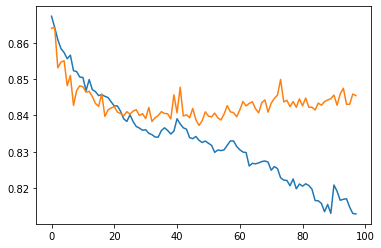

In [65]:
plt.plot(clf.history['loss'][5:])
plt.plot(clf.history['val_0_logloss'][5:])

## 7) Neural Network using PyTorch(미완성)
* PyTorch 튜토리얼 참고함
* 보기에는 loss가 낮게 나오긴 한데 validation set에 대한 accuracy도 낮고, 실제로 predict값을 확인해보면 학습할수록 예측값이 2로 치우쳐져 있음... 이것저것 해보면서 수정할 예정
* logloss는 아직 안뽑아봄

In [9]:
import os
import torch
from  torch import nn
from torch.utils.data import DataLoader, TensorDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device : {}'.format(device))

device : cuda


In [10]:
X_train_ts = torch.from_numpy(X_train.values)
Y_train_ts = np.reshape(Y_train.values, ((Y_train.values.shape[0], 1)))
Y_train_ts = torch.from_numpy(Y_train_ts)

X_val_ts = torch.from_numpy(X_val.values)
Y_val_ts = np.reshape(Y_val.values, ((Y_val.values.shape[0], 1)))
Y_val_ts = torch.from_numpy(Y_val_ts)

In [11]:
train_dataset = TensorDataset(X_train_ts, Y_train_ts)
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

val_dataset = TensorDataset(X_val_ts, Y_val_ts)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=True)

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(17, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(50, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
learning_rate = 1e-3

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        X=X.float()
        pred = model(X)
        y = y.reshape(y.shape[0],).long()
        #print(f"{pred.shape}, {y.shape}")
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss, current = loss.item(), batch * len(X)
    print(f"loss: {loss:>7f}")
            

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.float()
            pred = model(X)
            y = y.reshape(y.shape[0],).long()
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(val_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.043623
Test Error: 
 Accuracy: 54.4%, Avg loss: 0.105044 

Epoch 2
-------------------------------
loss: 0.990763
Test Error: 
 Accuracy: 62.8%, Avg loss: 0.099727 

Epoch 3
-------------------------------
loss: 0.967593
Test Error: 
 Accuracy: 64.6%, Avg loss: 0.096124 

Epoch 4
-------------------------------
loss: 0.924047
Test Error: 
 Accuracy: 64.3%, Avg loss: 0.094059 

Epoch 5
-------------------------------
loss: 0.919947
Test Error: 
 Accuracy: 64.6%, Avg loss: 0.092716 

Epoch 6
-------------------------------
loss: 0.917004
Test Error: 
 Accuracy: 64.6%, Avg loss: 0.091642 

Epoch 7
-------------------------------
loss: 0.901252
Test Error: 
 Accuracy: 64.6%, Avg loss: 0.091211 

Epoch 8
-------------------------------
loss: 0.911933
Test Error: 
 Accuracy: 64.6%, Avg loss: 0.090974 

Epoch 9
-------------------------------
loss: 0.904229
Test Error: 
 Accuracy: 64.6%, Avg loss: 0.090656 

Epoch 10
----------------------------